# Ciencia de Datos. TP2: Series Temporales

Axel Maddonni, LU 200/14 <br>
Federico Patane, LU 683/10<br>


*Septiembre 2017*

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sps
import scipy.io as sio
%matplotlib inline
matplotlib.style.use('ggplot')

def convertToDataFrame(data):
    epochs, electrodos, tiempos =  data.shape
    data = data.reshape((electrodos*epochs, tiempos))

    l1 = []
    l2 = []
    datos = []
    for x in range(0, electrodos) : 
        for y in range(0, epochs) : 
            l1.append(x)
            l2.append(y)

    l =  [l1,l2]
    tuples = list(zip(*l))

    index = pd.MultiIndex.from_tuples(tuples, names=['electrodos', 'epochs'])

    return pd.DataFrame(data, index=index)

def dataEpochs(df):
    return df.shape[0] / electrodos

electrodos, tiempos =  256, 201

In [88]:
dfs = [
    convertToDataFrame(sio.loadmat('P01.mat')['data']),
    convertToDataFrame(sio.loadmat('S02.mat')['data']),
    convertToDataFrame(sio.loadmat('P02.mat')['data']),
    convertToDataFrame(sio.loadmat('S01.mat')['data'])
]

In [118]:
dfs = [
    convertToDataFrame(sio.loadmat('P01.mat')['data']),
    convertToDataFrame(sio.loadmat('P02.mat')['data']),
    convertToDataFrame(sio.loadmat('P03.mat')['data']),
    convertToDataFrame(sio.loadmat('P04.mat')['data']),
    convertToDataFrame(sio.loadmat('P05.mat')['data']),
    convertToDataFrame(sio.loadmat('P06.mat')['data']),
    convertToDataFrame(sio.loadmat('P07.mat')['data']),
    convertToDataFrame(sio.loadmat('P08.mat')['data']),
    convertToDataFrame(sio.loadmat('P09.mat')['data']),
    convertToDataFrame(sio.loadmat('P10.mat')['data']),
    convertToDataFrame(sio.loadmat('S01.mat')['data']),
    convertToDataFrame(sio.loadmat('S02.mat')['data']),
    convertToDataFrame(sio.loadmat('S03.mat')['data']),
    convertToDataFrame(sio.loadmat('S04.mat')['data']),
    convertToDataFrame(sio.loadmat('S05.mat')['data']),
    convertToDataFrame(sio.loadmat('S06.mat')['data']),
    convertToDataFrame(sio.loadmat('S07.mat')['data']),
    convertToDataFrame(sio.loadmat('S08.mat')['data']),
    convertToDataFrame(sio.loadmat('S09.mat')['data']),
    convertToDataFrame(sio.loadmat('S10.mat')['data']) ]

In [119]:
def get_espectro(frecuencia, potencia):
    delta, theta, alpha, beta, gamma = 0, 0, 0, 0, 0
    i = 0
    while i < len(frecuencia) : 
        if frecuencia[i] < 4 : 
            delta += potencia[i]
        else : 
            if frecuencia[i] >= 4 and frecuencia[i] < 8 :
                theta += potencia[i]
            else : 
                if frecuencia[i] >= 8 and frecuencia[i] < 13 :
                    alpha += potencia[i]
                else : 
                    if frecuencia[i] >= 13 and frecuencia[i] < 30 :
                        beta += potencia[i]
                    else : 
                        gamma += potencia[i]
        i = i + 1
    return delta , theta , alpha , beta , gamma

def calcularBandasDeFrecuenciaMedia(data, paciente):
    deltaProm , thetaProm , alphaProm , betaProm , gammaProm = [], [], [], [], []
    bandas = []
    for e in (8,44,80,131,185):
        for i in range(0, dataEpochs(data)):
            f, Pxx_den = sps.welch(data.loc[e,i], fs=250)
            delta , theta , alpha , beta , gamma = get_espectro(f , Pxx_den)
            bandas.append(np.asarray([delta, theta, alpha, beta, gamma]))
    bandas = np.asarray(bandas).mean(axis=0)
    return bandas

n = 1
bandasFrecuenciaMedia = []
bandasFrecuenciaStd = []
bandasFrecuenciaNormMedia = []
bandasFrecuenciaNormStd = []

for data in dfs :
    if n < 11 :
        paciente = 'P' + str(n)
    else :
        paciente = 'S' + str(n-10)
    deltaProm , thetaProm , alphaProm , betaProm , gammaProm = [], [], [], [], []
    bandas = []
    bandasNorm = []
    for e in (8,44,80,131,185):
        for i in range(0, dataEpochs(data)):
            f, Pxx_den = sps.welch(data.loc[e,i], fs=250)
            delta , theta , alpha , beta , gamma = get_espectro(f , Pxx_den)
            total = delta + theta + alpha + beta + gamma
            bandas.append(np.asarray([delta, theta, alpha, beta, gamma]))
            bandasNorm.append(np.asarray([delta/total, theta/total, alpha/total, beta/total, gamma/total]))
    bandasMedia = np.asarray(bandas).mean(axis=0)
    bandasStd = np.asarray(bandas).std(axis=0)
    bandasNormMedia = np.asarray(bandasNorm).mean(axis=0)
    bandasNormStd = np.asarray(bandasNorm).std(axis=0)
    bandasFrecuenciaMedia.append(bandasMedia)
    bandasFrecuenciaStd.append(bandasStd)
    bandasFrecuenciaNormMedia.append(bandasNormMedia)
    bandasFrecuenciaNormStd.append(bandasNormStd)
    n = n + 1

bandasFrecuenciaMedia = np.asarray(bandasFrecuenciaMedia)
bandasFrecuenciaStd = np.asarray(bandasFrecuenciaStd)
bandasFrecuenciaNormMedia = np.asarray(bandasFrecuenciaNormMedia)
bandasFrecuenciaNormStd = np.asarray(bandasFrecuenciaNormStd)

In [120]:
from scipy.stats import entropy

def a_que_bin_pertenece(e, n_bins):
    if e == max(n_bins) : return len(n_bins) - 2
    i = 0
    while i < len(n_bins) - 1 : 
        if e >= n_bins[i] and e < n_bins[i + 1] : 
            return i
        i = i + 1
    return 0

def discretizar(epoch, n_bins): 
    epoch = epoch.tolist()
    epoch_discretizado = []
    for e in epoch : 
        epoch_discretizado.append(a_que_bin_pertenece(e, n_bins))
    return epoch_discretizado

def get_entropy(epoch, n_bins):
    epochs_discretizados = discretizar(epoch, n_bins)
    return entropy(epochs_discretizados)
    
def convert_electrodo_to_data(list_dfs_type, number_electrodo):
    #iterar la lista , y agarrar el electrodo 0 de cada paciente
    #a cada epoch hacerle el histogram y la entropia y dsp calcular con la de todos los epochs
    #y dsp calcular la entropia de todo la lista de pacientes
    entropia_pacientes_totales = np.array([])
    entropia_pacientes_totales_desvios = np.array([])
    for l in list_dfs_type : 
        electrodo_0 = l.iloc[l.index.get_level_values('electrodos') == number_electrodo]
        entropia_paciente = np.array([])
        for index , epoch in electrodo_0.iterrows(): 
            c_x_hist , n_bins = np.histogram(epoch, bins='fd')
            entropia_paciente = np.append(entropia_paciente, [get_entropy(epoch, n_bins)])
        p = np.average(entropia_paciente)
        p2 = np.std(entropia_paciente)
        entropia_pacientes_totales = np.append(entropia_pacientes_totales, [p])
        entropia_pacientes_totales_desvios = np.append(entropia_pacientes_totales_desvios, [p2])
    return entropia_pacientes_totales , entropia_pacientes_totales_desvios

intraElectrodos = []
intraElectrodosDesvios = [] 
for e in (8,44,80,131,185):
    a = convert_electrodo_to_data(dfs, e)
    intraElectrodos.append(np.asarray(a[0]))
    intraElectrodosDesvios.append(np.asarray(a[1]))

intraElectrodos = np.asarray(intraElectrodos)
intraElectrodosDesvios = np.asarray(intraElectrodosDesvios)
intraElectrodosMedia = intraElectrodos.mean(axis=0)
intraElectrodosDesvios = intraElectrodosDesvios.mean(axis=0)

In [122]:
features = []
for x in xrange(0,20):
    data = np.concatenate([
        bandasFrecuenciaMedia[x], bandasFrecuenciaStd[x],
        bandasFrecuenciaNormMedia[x], bandasFrecuenciaNormStd[x]])
    data = np.append(data, intraElectrodosMedia[x])
    data = np.append(data, intraElectrodosDesvios[x])
    features.append(data)
features = np.asarray(features)
print features

[[  2.89418232e-11   4.08542945e-12   2.04544940e-12   4.43373685e-12
    4.83347284e-12   5.71516496e-11   6.46769299e-12   2.45435500e-12
    1.41423236e-11   2.27090412e-11   5.99090724e-01   1.31109249e-01
    8.83711620e-02   1.06151601e-01   7.52772654e-02   2.49525221e-01
    1.17924080e-01   9.50640983e-02   1.04244242e-01   1.14244381e-01
    5.13295070e+00   8.32085928e-02]
 [  4.84271760e-11   1.00540108e-11   2.33305775e-12   4.83438659e-12
    2.39114155e-12   1.78377817e-10   3.02024203e-11   9.04475050e-12
    1.03255958e-11   4.24210590e-12   6.10848517e-01   2.05684101e-01
    4.98426167e-02   9.11176255e-02   4.25071389e-02   2.29725746e-01
    1.74086692e-01   4.95597391e-02   1.00382138e-01   5.09221497e-02
    5.12694987e+00   9.21697326e-02]
 [  4.94572681e-11   5.11430914e-12   1.64965870e-12   1.34475905e-12
    7.29500402e-13   8.39647371e-11   5.01146843e-12   1.74912076e-12
    1.54029958e-12   1.33997849e-12   7.39915895e-01   1.42780047e-01
    5.29611046e-

In [103]:
features[:,2]

array([  2.04544940e-12,   1.64248534e-11,   2.33305775e-12,
         2.19983091e-12])

0.1
0.25
0.89
0.62
0.52
0.09
0.22
0.83
0.47
0.43
0.0
0.35
1.0
0.86
0.7
0.25
0.22
0.94
0.55
0.58
0.99
0.0


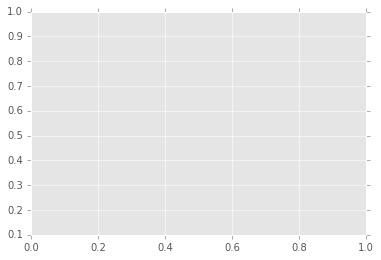

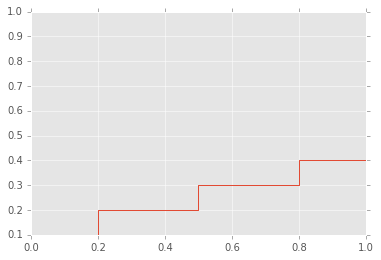

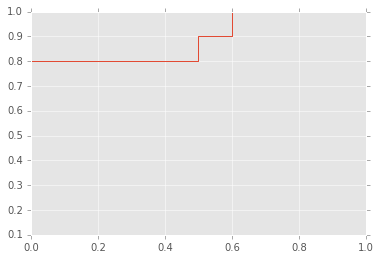

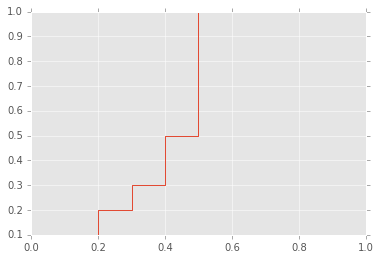

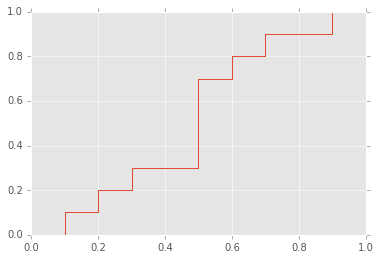

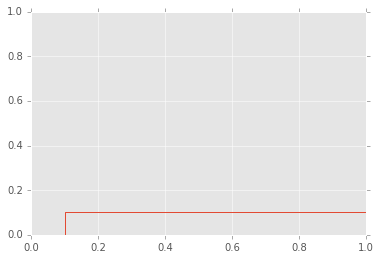

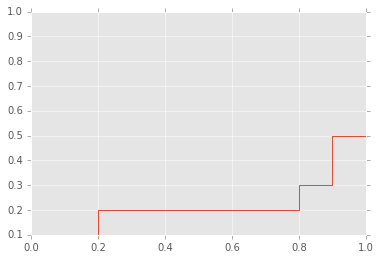

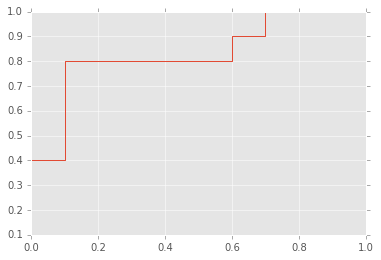

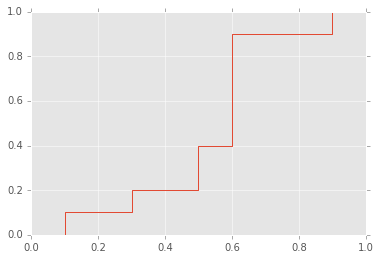

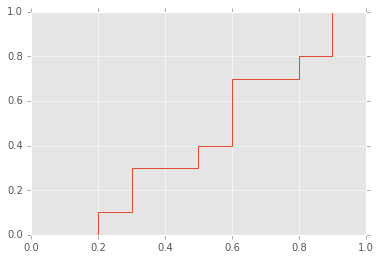

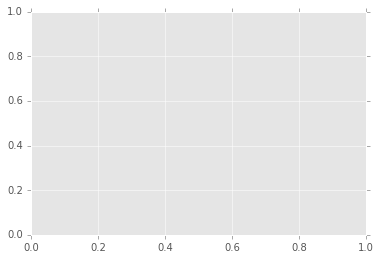

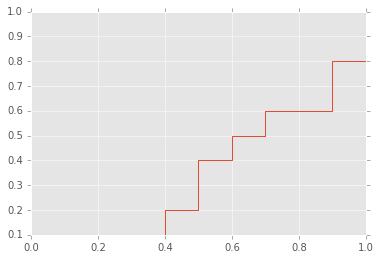

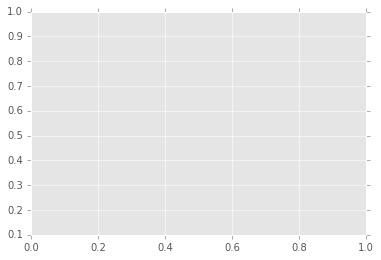

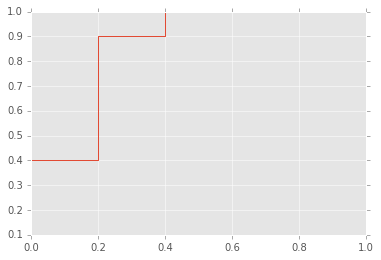

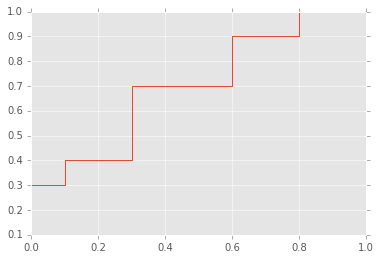

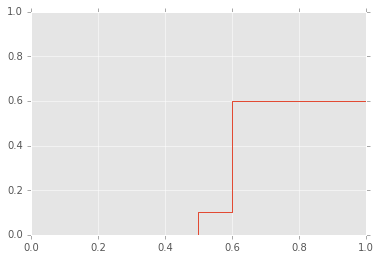

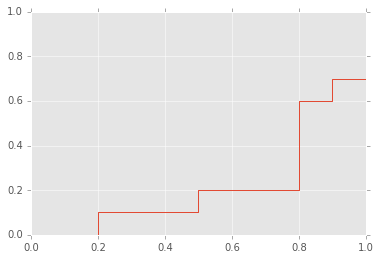

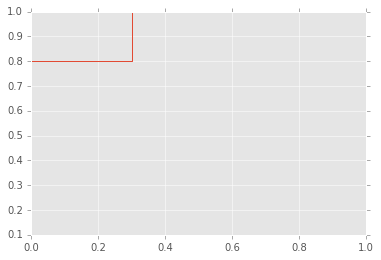

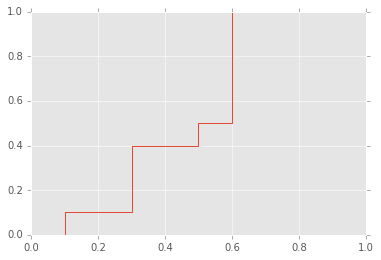

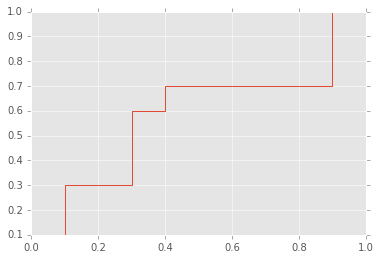

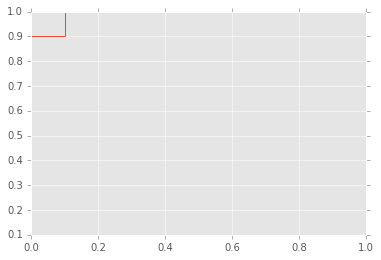

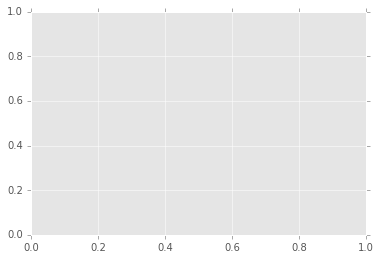

In [132]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

target1 = np.zeros(10)
target2 = np.ones(10)
target = np.concatenate((target1, target2), axis=0)

for f in xrange(0,22):
    fpr, tpr, thresholds = roc_curve(target,  features[:,f]) # obtener la curva ROC
    plt.figure()
    plt.plot(fpr,tpr) # plotear curva ROC
    print auc(fpr,tpr) # area de la curva ROC

In [150]:
from sklearn.model_selection import KFold # import KFold
X = np.array(features[:,2]) # array de features
y = np.array(target) # labels
kf = KFold(n_splits=5, shuffle=True) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print X_train
    fit(xtrain, ytrain)
    test*
    print X_test
    print y_train
    print y_test

KFold(n_splits=5, random_state=None, shuffle=True)
[  2.04544940e-12   2.33305775e-12   1.64965870e-12   2.85390368e-12
   1.46054573e-12   7.52051789e-13   4.93277783e-12   9.68055136e-13
   2.19983091e-12   1.64248534e-11   1.31241302e-11   1.77564281e-11
   1.26339204e-11   1.08958214e-11   1.91713418e-11   2.02724984e-12]
[  2.73694519e-12   3.98591872e-12   1.19878472e-11   1.77546986e-11]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.  0.  1.  1.]
[  2.04544940e-12   2.33305775e-12   1.64965870e-12   2.73694519e-12
   3.98591872e-12   2.85390368e-12   1.46054573e-12   4.93277783e-12
   9.68055136e-13   2.19983091e-12   1.64248534e-11   1.77564281e-11
   1.19878472e-11   1.77546986e-11   1.91713418e-11   2.02724984e-12]
[  7.52051789e-13   1.31241302e-11   1.26339204e-11   1.08958214e-11]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.]
[ 0.  1.  1.  1.]
[  1.64965870e-12   2.73694519e-12   3.98591872e-12   2.85390368e-12
   1.46054573e-12 